# Identifying Upselling/Cross-selling Opportunities with Market Basket Analysis and Cluster Analysis

## Exploratory Data Analysis

In [ ]:
#import the libraries we need to perform EDA
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [226]:
#dataset from https://www.kaggle.com/datasets/tunguz/online-retail
df = pd.read_csv('Online_Retail.csv', encoding='windows-1252')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,"17,850.00",United Kingdom


In [230]:
df.info()
#description and customerID columns have null values
#change column dtypes
df['CustomerID'] = df['CustomerID'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 37.2+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [231]:
#extract day and hour columns from InvoiceDate columns - in case we need it
df['Hour'] = df['InvoiceDate'].dt.strftime('%H:00')
df['Day'] = df['InvoiceDate'].dt.day_name()

In [8]:
df.groupby('StockCode')[['Quantity']].agg(['count', 'sum']).sort_values(('Quantity', 'count'), ascending = False)
#from this, we see that we have over 4k products with the most purchased purchased over 2.3k times

Quantity       
             count    sum
StockCode                
85123A        2313  38830
22423         2203  12980
85099B        2159  47363
47566         1727  18022
20725         1639  18979
...            ...    ...
85034b           1      1
21511            1     -9
84251F           1     -2
23652            1      2
m                1      1

[4070 rows x 2 columns]

Text(0.5, 1.0, 'Distribution of Product Purchase Frequency')

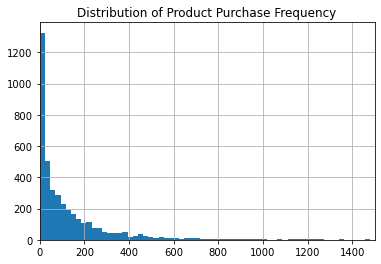

In [17]:
df.groupby('StockCode')[['Quantity']].count().hist(bins = 100)
plt.xlim(0, 1500)
plt.title('Distribution of Product Purchase Frequency')

#showing distribution of frequency for each product - majority of products only bought less than 200 times

In [45]:
pd.set_option('display.float_format', '{:,.2f}'.format)
df.groupby('CustomerID')[['Quantity']].count()
#there are 4.4k customers but we have missing customerID for 135k transactions - will have to exclude these from customer cluster analysis

,Quantity
CustomerID,
12346.0,2
12347.0,182
12348.0,31
12349.0,73
12350.0,17
...,...
18281.0,7
18282.0,13
18283.0,756


(0.0, 200.0)

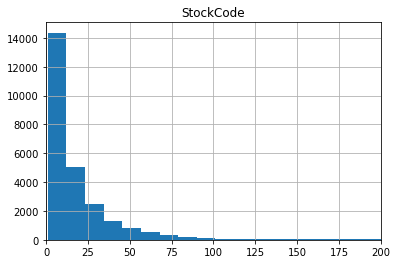

In [69]:
df.groupby('InvoiceNo')[['StockCode']].count().hist(bins = 100)
plt.xlim(0, 200)
#most invoices are only for 0-25 items

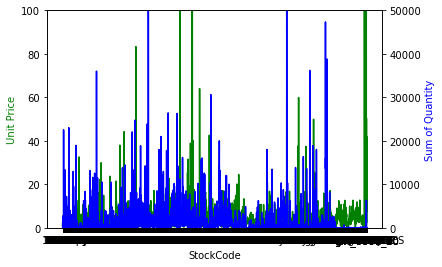

In [102]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df.groupby('StockCode')[['UnitPrice']].mean(), 'g-')
ax2.plot(df.groupby('StockCode')[['Quantity']].sum(), 'b-')

ax1.set_ylim(0, 100)
ax1.set_xlabel('StockCode')
ax1.set_ylabel('Unit Price', color='g')
ax2.set_ylim(0, 50000)
ax2.set_ylabel('Sum of Quantity', color='b')

plt.show()

<AxesSubplot:>

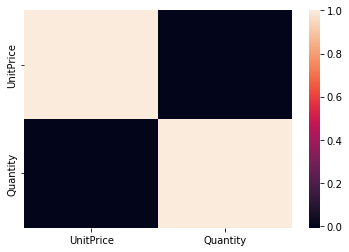

In [103]:
sns.heatmap(df.groupby('StockCode')[['UnitPrice']].mean().join(df.groupby('StockCode')[['Quantity']].sum()).corr())
#there does not seem to be a correlation between unit price and the quantity of products bought

## Market Basket Analysis to Identify Bundling Opportunities

In [108]:
#to begin market basket analysis, we want to see the quantity bought for each product for each invoice
basket = df.pivot_table(index = 'InvoiceNo', columns = 'StockCode', values = 'Quantity', aggfunc = 'sum').fillna(0)
#using the pandas pivot_table we can see each invoice's product mix
df.pivot_table(index = 'InvoiceNo', columns = 'StockCode', values = 'Quantity', aggfunc = 'sum').fillna(0)

StockCode,10002,10080,10120,10123C,10123G,10124A,10124G,10125,10133,10134,...,M,PADS,POST,S,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
536366,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
536367,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
536368,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
536369,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C581484,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
C581490,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
C581499,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [136]:
#since we are only interested in whether products are bought to together and not the quantity, encode the value to take the value of 1 if quantity bought is > 0, and 0 if otherwise
be = basket.where(basket <= 0, 1)

In [145]:
#now we only want the invoices that have multiple products bought
dfb = be[be.sum(1) > 1]

In [154]:
from mlxtend.frequent_patterns import apriori, association_rules

#we use the apriori algorithm to determine which item sets appear frequently and their support levels
#we use a minimum support level of 0.03 
#support is the probability that the item was bought in any transaction

dfmba = apriori(dfb, min_support = 0.03, use_colnames = True)
dfmba['len'] = [len(x) for x in dfmba['itemsets']]
dfmba.sort_values('support', ascending = False)

C:\Users\MXW26\Anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets,len
145,0.12,(85123A),1
142,0.11,(85099B),1
62,0.11,(22423),1
122,0.09,(47566),1
7,0.09,(20725),1
...,...,...,...
44,0.03,(22113),1
150,0.03,"(20725, 20728)",2
91,0.03,(22867),1
54,0.03,(22367),1


In [403]:
#from above, we have 166 items that are frequently bought with stockcode 85123A being the most purchased - confirms what we saw during the EDA phase
#now we move onto finding the association between the products

#mlxtend's association rules class transforms our apriori output to quantity association rules
#most important ones are
#support - as explained above
#confidence is the probability of both the antecedent and the consequent item appearing in the same transaction ---> this is calculated by support / probability of antecedent item (i.e. its support level)
#lift is the ratio of confidence of the association rule and the expected confidence of the rule, a lift measure the rule's importance i.e. a lift > 1 indicates an assocation, higher lift means stronger association ---> this is calculated by confidence / probability of consequent item (i.e. its support level)
#conviction measure the strength of the relationship's direction ---> a conviction > 1 indicates relationship, the higher the conviction the stronger the relationship

association_rules(dfmba, metric = 'lift', min_threshold = 1).sort_values('confidence', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
22,(22698),(22697),0.04,0.06,0.03,0.83,15.03,0.03,5.62
26,(22698),(22699),0.04,0.06,0.03,0.79,13.58,0.03,4.43
25,(22697),(22699),0.06,0.06,0.04,0.76,13.05,0.04,3.87
24,(22699),(22697),0.06,0.06,0.04,0.72,13.05,0.04,3.40
18,(22386),(85099B),0.07,0.11,0.04,0.68,5.99,0.04,2.76
17,(22910),(22086),0.04,0.06,0.03,0.68,10.76,0.03,2.90
29,(22726),(22727),0.05,0.06,0.03,0.66,11.46,0.03,2.74
32,(85099C),(85099B),0.05,0.11,0.03,0.63,5.57,0.03,2.40
23,(22697),(22698),0.06,0.04,0.03,0.62,15.03,0.03,2.55
14,(21931),(85099B),0.06,0.11,0.04,0.61,5.40,0.03,2.28


In [190]:
dfar = association_rules(dfmba, metric = 'lift', min_threshold = 1).sort_values('lift', ascending = False)

#to see what the item stockcodes' descriptions are, we need to extract the code from the frozenset that apriori algo creates and join it to the description in the main dataframe

l = []
for i in dfar['antecedents']:
    x , = i
    l.append(x)
dfar['AntCode'] = l
l = []
for i in dfar['consequents']:
    x , = i
    l.append(x)
dfar['ConCode'] = l
dfar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,AntCode,ConCode
22,(22698),(22697),0.04,0.06,0.03,0.83,15.03,0.03,5.62,22698,22697
23,(22697),(22698),0.06,0.04,0.03,0.62,15.03,0.03,2.55,22697,22698
27,(22699),(22698),0.06,0.04,0.03,0.56,13.58,0.03,2.20,22699,22698
26,(22698),(22699),0.04,0.06,0.03,0.79,13.58,0.03,4.43,22698,22699
25,(22697),(22699),0.06,0.06,0.04,0.76,13.05,0.04,3.87,22697,22699
24,(22699),(22697),0.06,0.06,0.04,0.72,13.05,0.04,3.40,22699,22697
28,(22727),(22726),0.06,0.05,0.03,0.61,11.46,0.03,2.42,22727,22726
29,(22726),(22727),0.05,0.06,0.03,0.66,11.46,0.03,2.74,22726,22727
16,(22086),(22910),0.06,0.04,0.03,0.48,10.76,0.03,1.83,22086,22910
17,(22910),(22086),0.04,0.06,0.03,0.68,10.76,0.03,2.90,22910,22086


In [193]:
#here we have the items that are commonly purchased together along with our confidence level in their relationshipo
dfar.join(df.groupby('StockCode')[['Description']].first(), on = 'AntCode', how = 'left').join(df.groupby('StockCode')[['Description']].first(), on = 'ConCode', how = 'left', rsuffix = ' Consequent')[['Description', 'Description Consequent', 'support', 'confidence', 'lift']]

,Description,Description Consequent,support,confidence,lift
22,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.03,0.83,15.03
23,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.03,0.62,15.03
27,ROSES REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.03,0.56,13.58
26,PINK REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.03,0.79,13.58
25,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.04,0.76,13.05
24,ROSES REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.04,0.72,13.05
28,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE GREEN,0.03,0.61,11.46
29,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,0.03,0.66,11.46
16,PAPER CHAIN KIT 50'S CHRISTMAS,PAPER CHAIN KIT VINTAGE CHRISTMAS,0.03,0.48,10.76
17,PAPER CHAIN KIT VINTAGE CHRISTMAS,PAPER CHAIN KIT 50'S CHRISTMAS,0.03,0.68,10.76


## Using Cluster Analysis to group Customers

In [232]:
#from EDA, we know we have about 4.3k customers excluding null values
df[df['CustomerID'] != 'nan'].groupby('CustomerID')[['Quantity']].agg(['count', 'sum'])

Quantity      
              count   sum
CustomerID               
12346.0           2     0
12347.0         182  2458
12348.0          31  2341
12349.0          73   631
12350.0          17   197
...             ...   ...
18280.0          10    45
18281.0           7    54
18282.0          13    98
18283.0         756  1397
18287.0          70  1586

[4372 rows x 2 columns]

### We would like to cluster our customers according to Recency, Frequency, and Monetary Value, a.k.a RFM Clusters.
### To achive this, we need to calcualte Recency, Frequency and Monetary Value scores for each customer


In [233]:
#remove all missing customerID values
df = df[df['CustomerID'] != 'nan']

In [234]:
#to calculate recency, we use the latest invoice date as today
dfr = df.groupby('CustomerID')[['InvoiceDate']].max().reset_index()
dfr['Recency'] = (dfr['InvoiceDate'].max() - dfr['InvoiceDate']).dt.days

<AxesSubplot:>

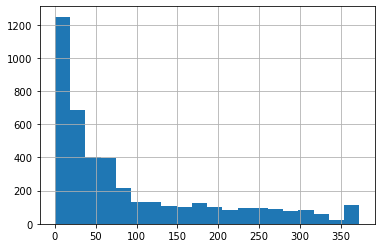

In [235]:
dfr['Recency'].hist(bins = 20)
#we can see that most customers have made a purchase in the last 50 days

In [236]:
#use pd.describe to see descriptive stats of recency column
dfr['Recency'].describe()

count   4,372.00
mean       91.05
std       100.77
min         0.00
25%        16.00
50%        49.00
75%       142.00
max       373.00
Name: Recency, dtype: float64

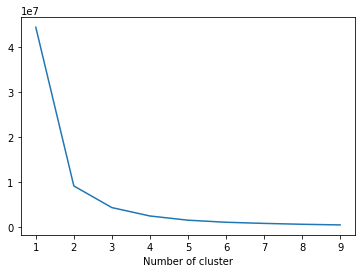

In [237]:
#now we use KMeans clustering to assign a recency score
#to determine the number of clusters that returns the lowest error, we use the elbow method and plot the number of clusters against the sse score (i.e intertia)
from sklearn.cluster import KMeans

sse={}
recency = dfr[['Recency']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()
#from this, we can see that 3 clusters is optimal

In [238]:
#join recency back to main df
df = df.join(dfr[['CustomerID', 'Recency']].set_index('CustomerID'), on = 'CustomerID', how = 'left')

In [239]:
#use KMeans to cluster recency into three clusters
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df[['Recency']])
df['RCluster'] = kmeans.predict(df[['Recency']])

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Hour,Day,Recency,RCluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,08:00,Wednesday,301,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,08:00,Wednesday,301,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,12:00,Friday,0,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12:00,Friday,0,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12:00,Friday,0,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12:00,Friday,0,0


In [242]:
#we want to see the descriptive stats for each cluster 
df.groupby('RCluster')[['Recency']].describe()
#since the clusters are not ordered, we see that Cluster 1 is the most recent, with cluster 3 being the least recent

Recency                                                
              count   mean   std    min    25%    50%    75%    max
RCluster                                                           
0        325,510.00  13.47 13.83   0.00   2.00   9.00  22.00  54.00
1         22,779.00 258.22 57.69 177.00 207.00 253.00 304.00 373.00
2         58,540.00  95.34 34.96  55.00  66.00  84.00 120.00 176.00

In [241]:
#now we do the same for frequency and revenue
dff = df[df['CustomerID'] != 'nan'].groupby('CustomerID')[['Quantity']].count().reset_index()
dff.columns = ['CustomerID', 'Frequency']

In [243]:
dff

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


In [249]:
df = df.join(dff.set_index('CustomerID'), on = 'CustomerID', how = 'left')

In [250]:
#use KMeans to cluster recency into three clusters
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df[['Frequency']])
df['FCluster'] = kmeans.predict(df[['Frequency']])

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Hour,Day,Recency,RCluster,Frequency,FCluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,12:00,Friday,0,0,52,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12:00,Friday,0,0,52,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12:00,Friday,0,0,52,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12:00,Friday,0,0,52,0


In [262]:
df.groupby('FCluster')[['Frequency']].describe()
#from this, we can see that FCluster 1 is the most frequent cluster, and cluster 0 the least frequent

Frequency                                                        \
              count     mean      std      min      25%      50%      75%   
FCluster                                                                    
0        351,651.00   223.93   185.48     1.00    81.00   165.00   320.00   
1         23,656.00 6,189.48 1,349.16 4,642.00 5,128.00 5,903.00 7,983.00   
2         31,522.00 1,551.74   590.16   898.00 1,094.00 1,284.00 1,857.00   

                   
              max  
FCluster           
0          872.00  
1        7,983.00  
2        2,782.00

In [263]:
#to calculate monetary value we will need to calculate the value of each invoice line i.e. price * Quantity
df['Value'] = df['Quantity'] * df['UnitPrice']

In [265]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Hour,Day,Recency,RCluster,Frequency,FCluster,Value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,20.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,12:00,Friday,0,0,52,0,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12:00,Friday,0,0,52,0,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12:00,Friday,0,0,52,0,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12:00,Friday,0,0,52,0,16.60


In [270]:
dfm = df.groupby('CustomerID')[['Value']].sum()
dfm.columns = ['MV']
df = df.join(dfm, on = 'CustomerID', how = 'left')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Hour,Day,Recency,RCluster,Frequency,FCluster,Value,MV
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,15.30,"5,288.63"
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,20.34,"5,288.63"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,22.00,"5,288.63"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,20.34,"5,288.63"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,20.34,"5,288.63"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,12:00,Friday,0,0,52,0,10.20,862.81
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12:00,Friday,0,0,52,0,12.60,862.81
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12:00,Friday,0,0,52,0,16.60,862.81
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12:00,Friday,0,0,52,0,16.60,862.81


In [272]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df[['MV']])
df['MVCluster'] = kmeans.predict(df[['MV']])

#show details of the dataframe
df.groupby('MVCluster')['Value'].describe()
#MVCluster 1 is the highest revenue-generating cluster, whereas MVCluster 0 is the least

,count,mean,std,min,25%,50%,75%,max
MVCluster,,,,,,,,
0,"381,301.00",17.06,437.51,"-168,469.60",4.16,10.50,17.85,"168,469.60"
1,"2,869.00",252.15,473.05,"-3,825.36",62.40,127.50,240.00,"7,144.72"
2,"22,659.00",47.28,160.03,"-8,142.75",7.46,16.58,39.60,"8,142.75"


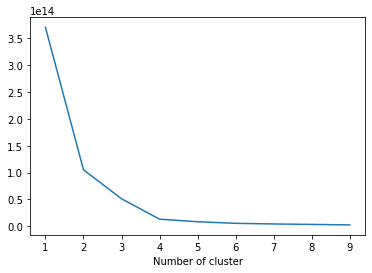

In [283]:
#we want to use the elbow method to determine the optimal number of clusters for the overall score
sse={}
os = df[['Recency', 'Frequency', 'MV']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(os)
    os["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()
#use 4 clusters

In [378]:
#now we want to work out a total RFM score for each customer
km = KMeans(n_clusters = 4)
km.fit(df[['RCluster', 'FCluster', 'MVCluster']])
df['Overall Cluster'] = km.predict(df[['RCluster', 'FCluster', 'MVCluster']])

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Hour,Day,Recency,RCluster,Frequency,FCluster,Value,MV,MVCluster,Overall Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,15.30,"5,288.63",0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,20.34,"5,288.63",0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,22.00,"5,288.63",0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,20.34,"5,288.63",0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:00,Wednesday,301,1,312,0,20.34,"5,288.63",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,12:00,Friday,0,0,52,0,10.20,862.81,0,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12:00,Friday,0,0,52,0,12.60,862.81,0,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12:00,Friday,0,0,52,0,16.60,862.81,0,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12:00,Friday,0,0,52,0,16.60,862.81,0,0


In [380]:
#now we create a few different charts to visualize the distribution of customer clusters with altair scatterplots
import altair as alt
alt.Chart(df.groupby('CustomerID')[['Recency', 'Frequency', 'MV', 'Overall Cluster']].first()).mark_circle(size=60).encode(
    x='Frequency:Q',
    y='MV:Q',
    color='Overall Cluster:N',
    tooltip=['MV', 'Frequency', 'Recency']
).interactive().properties(
    width=1500,
    height=600
)

alt.Chart(...)

In [382]:
import altair as alt
alt.Chart(df.groupby('CustomerID')[['Recency', 'Frequency', 'MV', 'Overall Cluster']].first()).mark_circle(size=60).encode(
    x='Frequency',
    y='MV',
    color='Overall Cluster:N',
    tooltip=['MV', 'Frequency', 'Recency']
).interactive().properties(
    width=1500,
    height=600
)

alt.Chart(...)

In [383]:
alt.Chart(df.groupby('CustomerID')[['Recency', 'Frequency', 'MV', 'Overall Cluster']].first()).mark_circle(size=60).encode(
    x='Recency',
    y='MV',
    color='Overall Cluster:N',
    tooltip=['MV', 'Frequency', 'Recency']
).interactive().properties(
    width=1500,
    height=600
)

alt.Chart(...)

In [402]:
base = alt.Chart(df.groupby('CustomerID')[['Recency', 'Frequency', 'MV', 'Overall Cluster']].first()).encode(
    alt.X('Recency', axis=alt.Axis(title='Recency')), shape='Overall Cluster:N',
    tooltip=['MV', 'Frequency', 'Recency']
).properties(
    width=1500,
    height=600
)

rec = base.mark_circle(opacity=0.3, shape='Overall Cluster:N').encode(
    alt.Y('Frequency',
          axis=alt.Axis(title='Frequency', titleColor='r')),
    alt.Y2('MV')
)

mv = base.mark_point(shape='Overall Cluster:N').encode(
    alt.Y('MV',
          axis=alt.Axis(title='Monetary Value', titleColor='b'))
)

alt.layer(area, line).resolve_scale(
    y = 'independent'
)

alt.LayerChart(...)

In [393]:
pd.set_option('display.max_columns', None)
df.groupby('Overall Cluster')[['Recency', 'Frequency', 'MV']].describe()

Recency                                              \
                     count  mean   std   min   25%   50%    75%    max   
Overall Cluster                                                          
0               302,592.00 33.23 67.50  0.00  3.00 12.00  29.00 373.00   
1                58,540.00 95.34 34.96 55.00 66.00 84.00 120.00 176.00   
2                22,659.00  3.34  5.94  0.00  0.00  2.00   3.00  38.00   
3                23,038.00  5.88  7.72  0.00  0.00  2.00   9.00  32.00   

                 Frequency                                             \
                     count     mean      std    min      25%      50%   
Overall Cluster                                                         
0               302,592.00   514.25 1,355.70   1.00    97.00   201.00   
1                58,540.00   115.64    98.53   1.00    45.00    87.00   
2                22,659.00 3,455.79 2,114.52  79.00 1,640.00 2,491.00   
3                23,038.00 1,449.63   592.47 898.00 1,061.00 1,165.00   

                                          MV                                \
                     75%      max      count      mean       std       min   
Overall Cluster                                                              
0                 384.00 7,983.00 302,592.00  5,739.64 13,867.59 -1,192.20   
1                 153.00   548.00  58,540.00  1,568.18  1,480.12 -4,287.63   
2               5,903.00 5,903.00  22,659.00 83,784.66 34,288.92 50,415.49   
3               1,677.00 2,782.00  23,038.00 33,660.29 77,755.34  3,047.63   

                                                           
                      25%       50%        75%        max  
Overall Cluster                                            
0                1,111.79  2,556.68   5,192.10 256,438.49  
1                  582.47  1,130.57   2,103.06  11,581.80  
2               57,120.91 59,419.34 132,572.62 132,572.62  
3                5,043.96  7,839.51  11,713.85 279,489.02

In [401]:
df.groupby(['Overall Cluster'])[['CustomerID']].nunique()

,CustomerID
Overall Cluster,
0,3178
1,1161
2,15
3,18


#### From these charts, we can see that most customers (3178) fall into Cluster 0 - Low Frequency, Medium Frequency, Medium Value. Cluster 1 is the next largest (1161 customers) with Lowest MV, Lowest Frequency, Highest Recency - these are the Overall Lowest Value Customers. Cluster 2 (15 customers) are the highest value customers with Highest Frequency, Recency and MV. Cluster 3 is second in all three categories (18 customers).
#### Potential next steps, reward customers in Clusters 2 and 3. Use Market Basket Analysis to upsell to customers in Cluster 1 to increase value per customer. Design new marketing strategies for Cluster 0